# **AntiMicrobial Resistance Prediction from SNPs**

This notebook contains the end-to-end Explainable XGBoost implementation of **AMR Prediction from SNPs** project. Feel free to use/customise the code.

##**Setup & Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CIP**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# --- XGBoost and Scikit-learn Imports ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    f1_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef
)
import shap # For explainability

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CIP" # Or "CTX", "CTZ", "GEN"

# Data Splitting Ratios
TEST_SPLIT = 0.2

# Setting seed for reproducibility
np.random.seed(42)

print("Setup Complete. Using XGBoost for classification.")

Setup Complete. Using XGBoost for classification.


# **Data Preprocessing**

In [ ]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separating features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 366, Susceptible (0): 443


# **Data Splitting**

In [ ]:
print("\n--- Splitting Data ---")

# Splitting the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


# **Model Definition & Training**

In [ ]:
print("\n--- Defining and Training the XGBoost Model ---")

# --- Hyperparameter Selection ---
# Calculating scale_pos_weight based on the training set
neg_count, pos_count = np.bincount(y_train)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.4f}")

# Other common hyperparameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'random_state': 42,
    #'tree_method': 'gpu_hist',
    'early_stopping_rounds': 50
}

# --- Model Instantiation ---
xgb_model = xgb.XGBClassifier(**xgb_params)

print(f"Training XGBoost with up to {xgb_params['n_estimators']} trees...")

# --- Training ---
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"\nTraining complete. Best iteration found at tree #{xgb_model.best_iteration}")

# --- SAVING THE FINAL MODEL ---
XGB_MODEL_PATH = "best_xgboost_model_CIP.json"
print(f"Saving the final XGBoost model to {XGB_MODEL_PATH}...")
xgb_model.save_model(XGB_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the XGBoost Model ---
Calculated scale_pos_weight for XGBoost: 1.2082
Training XGBoost with up to 1000 trees...

Training complete. Best iteration found at tree #98
Saving the final XGBoost model to best_xgboost_model_CIP.json...
Model saved successfully.


# **Model Evaluation**


--- Evaluating XGBoost Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.9630
AUC Score: 0.9865
Cohen's Kappa: 0.9250
Matthews Correlation Coefficient (MCC): 0.9253

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.9560    0.9775    0.9667        89
  Resistant (1)     0.9718    0.9452    0.9583        73

       accuracy                         0.9630       162
      macro avg     0.9639    0.9614    0.9625       162
   weighted avg     0.9632    0.9630    0.9629       162


Confusion Matrix:


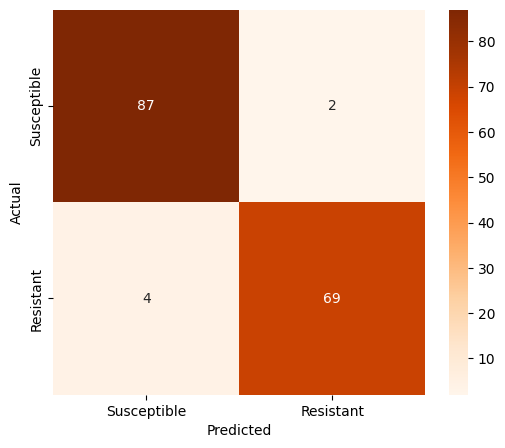

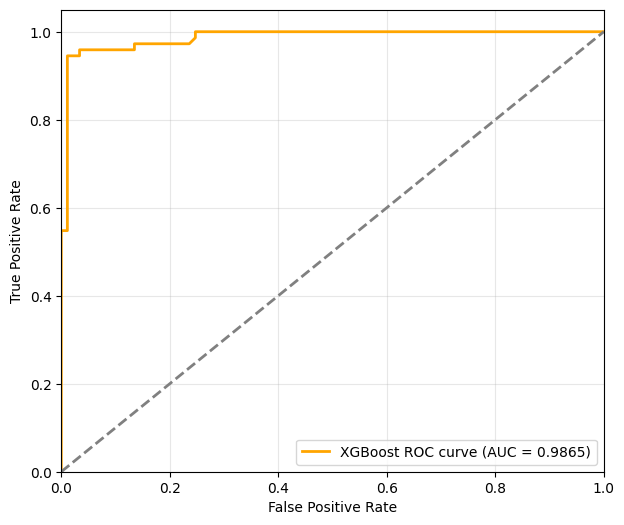

In [ ]:
print("\n--- Evaluating XGBoost Model on Test Set ---")

# --- Making Predictions ---
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# --- Calculating All Metrics ---
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_probs_xgb)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC Score: {auc_xgb:.4f}")
print(f"Cohen's Kappa: {kappa_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")

# --- Classification Report (formatted to 4 decimal places) ---
print("\nClassification Report:")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report_xgb)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.show()

# --- ROC Curve ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_probs_xgb)
plt.figure(figsize=(7, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost ROC curve (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- XGBoost Explainability: SHAP Feature Importances ---
Calculating SHAP values for the test set...
Plotting global SHAP feature importance...


/tmp/ipython-input-2517317453.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


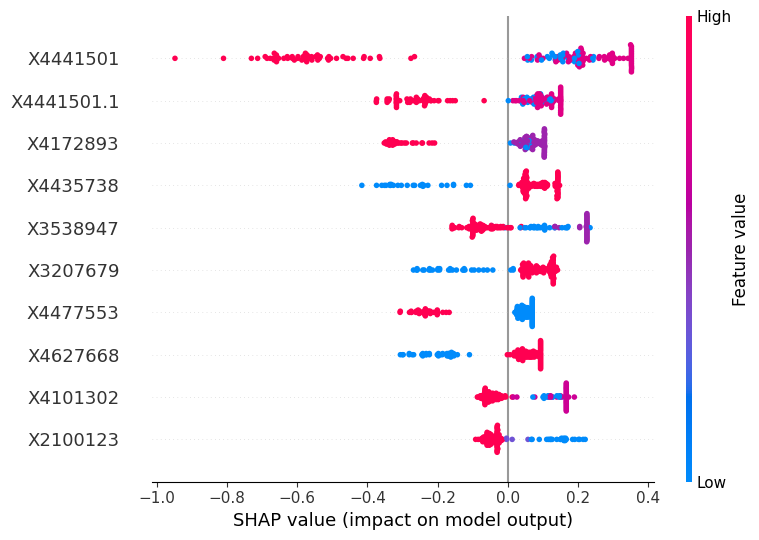


Explaining prediction for test sample index 0 (SHAP force plot)...


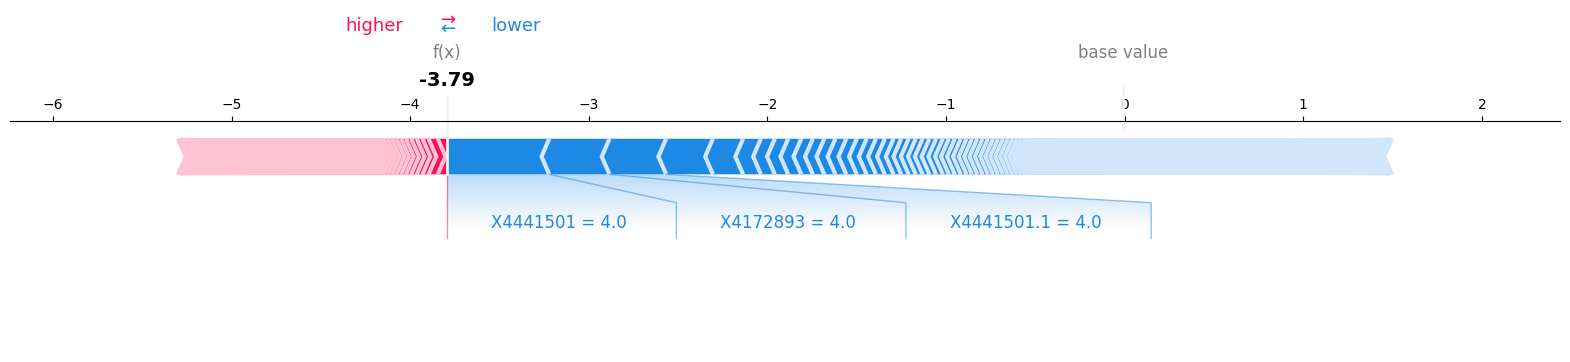


--- Explainability Analysis Complete ---
In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.
A high SHAP value means that feature pushed the prediction towards 'Resistant'.


In [ ]:
print("\n--- XGBoost Explainability: SHAP Feature Importances ---")

# Creating a SHAP explainer object.
explainer_xgb = shap.TreeExplainer(xgb_model)

# Calculating SHAP values for the test set.
print("Calculating SHAP values for the test set...")
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Converting the test data to a DataFrame for better plotting with feature names
X_test_df = pd.DataFrame(X_test, columns=snp_position_names)

# --- Global Feature Importance Plot (SHAP Summary Plot) ---
print("Plotting global SHAP feature importance...")
plt.figure()
shap.summary_plot(
    shap_values_xgb,
    X_test_df,
    max_display=10,
    show=False
)
#plt.title(f'Top SHAP Feature Importances for {TARGET_ANTIBIOTIC} (XGBoost)')
plt.tight_layout()
plt.show()

# --- Individual Prediction Explanation (Force Plot) ---
sample_to_explain_idx = 0
print(f"\nExplaining prediction for test sample index {sample_to_explain_idx} (SHAP force plot)...")
shap.initjs()
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_to_explain_idx, :],
    X_test_df.iloc[sample_to_explain_idx, :],
    matplotlib=True,
    show=True
)

print("\n--- Explainability Analysis Complete ---")
print("In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.")
print("A high SHAP value means that feature pushed the prediction towards 'Resistant'.")

# **CTX**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# --- XGBoost and Scikit-learn Imports ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    f1_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef
)
import shap # For explainability

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CTX"

# Data Splitting Ratios
TEST_SPLIT = 0.2

np.random.seed(42)

print("Setup Complete. Using XGBoost for classification.")

Setup Complete. Using XGBoost for classification.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 358, Susceptible (0): 451


# **Data Splitting**

In [ ]:
print("\n--- Splitting Data ---")

# Splitting the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


# **Model Definition & Training**

In [ ]:
print("\n--- Defining and Training the XGBoost Model ---")

# --- Hyperparameter Selection ---
neg_count, pos_count = np.bincount(y_train)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.4f}")

# Other common hyperparameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'random_state': 42,
    #'tree_method': 'gpu_hist',
    'early_stopping_rounds': 50
}

# --- Model Instantiation ---
xgb_model = xgb.XGBClassifier(**xgb_params)

print(f"Training XGBoost with up to {xgb_params['n_estimators']} trees...")

# --- Training ---
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"\nTraining complete. Best iteration found at tree #{xgb_model.best_iteration}")

# --- SAVING THE FINAL MODEL ---
XGB_MODEL_PATH = "best_xgboost_model_CTX.json"
print(f"Saving the final XGBoost model to {XGB_MODEL_PATH}...")
xgb_model.save_model(XGB_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the XGBoost Model ---
Calculated scale_pos_weight for XGBoost: 1.2622
Training XGBoost with up to 1000 trees...

Training complete. Best iteration found at tree #78
Saving the final XGBoost model to best_xgboost_model_CTX.json...
Model saved successfully.


# **Model Evaluation**


--- Evaluating XGBoost Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.8025
AUC Score: 0.8853
Cohen's Kappa: 0.6033
Matthews Correlation Coefficient (MCC): 0.6050

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8452    0.7889    0.8161        90
  Resistant (1)     0.7564    0.8194    0.7867        72

       accuracy                         0.8025       162
      macro avg     0.8008    0.8042    0.8014       162
   weighted avg     0.8058    0.8025    0.8030       162


Confusion Matrix:


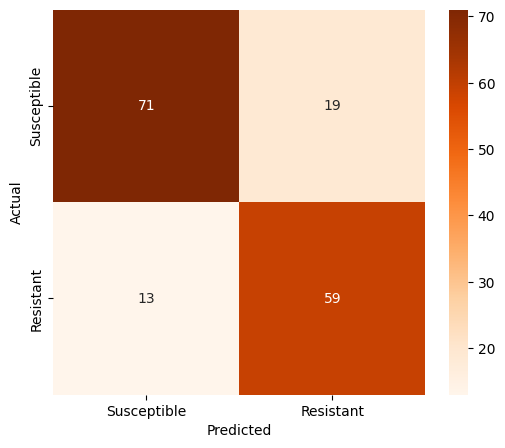

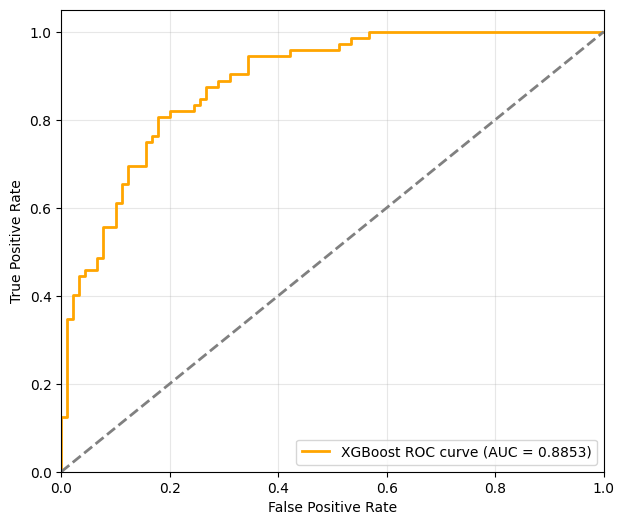

In [ ]:
print("\n--- Evaluating XGBoost Model on Test Set ---")

y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# --- Calculating All Metrics ---
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_probs_xgb)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC Score: {auc_xgb:.4f}")
print(f"Cohen's Kappa: {kappa_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report_xgb)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.show()

# --- ROC Curve ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_probs_xgb)
plt.figure(figsize=(7, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost ROC curve (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- XGBoost Explainability: SHAP Feature Importances ---
Calculating SHAP values for the test set...
Plotting global SHAP feature importance...


/tmp/ipython-input-2517317453.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


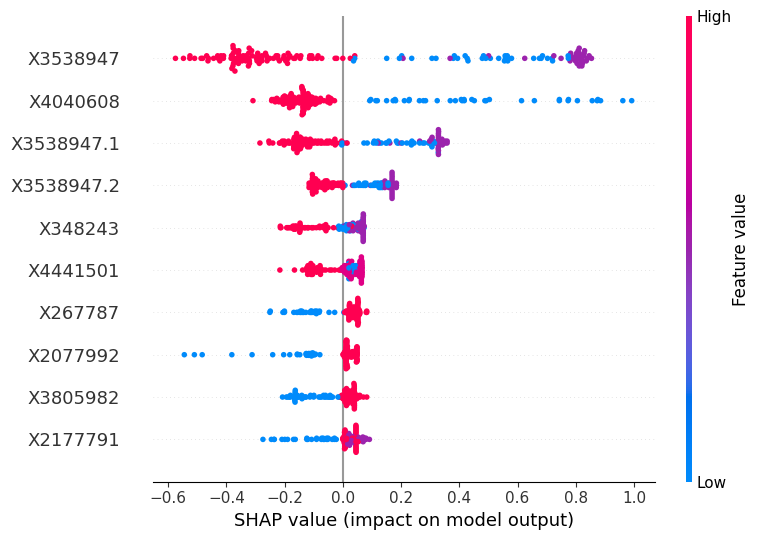


Explaining prediction for test sample index 0 (SHAP force plot)...


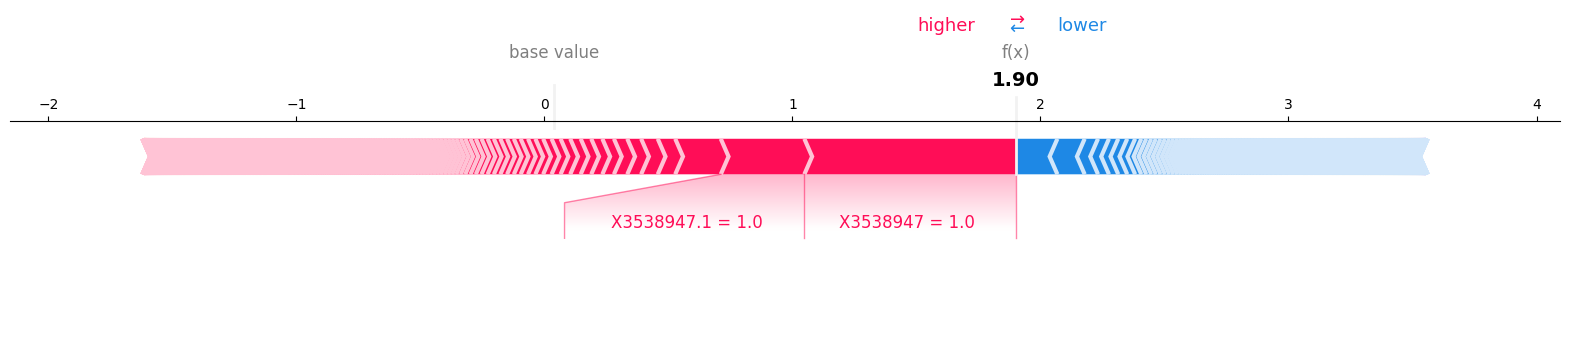


--- Explainability Analysis Complete ---
In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.
A high SHAP value means that feature pushed the prediction towards 'Resistant'.


In [ ]:
print("\n--- XGBoost Explainability: SHAP Feature Importances ---")

explainer_xgb = shap.TreeExplainer(xgb_model)

print("Calculating SHAP values for the test set...")
shap_values_xgb = explainer_xgb.shap_values(X_test)

X_test_df = pd.DataFrame(X_test, columns=snp_position_names)

# --- Global Feature Importance Plot (SHAP Summary Plot) ---
print("Plotting global SHAP feature importance...")
plt.figure()
shap.summary_plot(
    shap_values_xgb,
    X_test_df,
    max_display=10,
    show=False
)
#plt.title(f'Top SHAP Feature Importances for {TARGET_ANTIBIOTIC} (XGBoost)')
plt.tight_layout()
plt.show()

# --- Individual Prediction Explanation (Force Plot) ---
sample_to_explain_idx = 0
print(f"\nExplaining prediction for test sample index {sample_to_explain_idx} (SHAP force plot)...")
shap.initjs()
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_to_explain_idx, :],
    X_test_df.iloc[sample_to_explain_idx, :],
    matplotlib=True,
    show=True
)

print("\n--- Explainability Analysis Complete ---")
print("In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.")
print("A high SHAP value means that feature pushed the prediction towards 'Resistant'.")

# **CTZ**

In [ ]:
# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CTZ"

# Data Splitting Ratios
TEST_SPLIT = 0.2

np.random.seed(42)

print("Setup Complete. Using XGBoost for classification.")

Setup Complete. Using XGBoost for classification.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

snp_position_names = features_df.columns.tolist()

X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 276, Susceptible (0): 533


# **Data Splitting**

In [ ]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


# **Model Definition & Training**

In [ ]:
print("\n--- Defining and Training the XGBoost Model ---")

# --- Hyperparameter Selection ---
neg_count, pos_count = np.bincount(y_train)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.4f}")

# Other common hyperparameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'random_state': 42,
    #'tree_method': 'gpu_hist',
    'early_stopping_rounds': 50
}

# --- Model Instantiation ---
xgb_model = xgb.XGBClassifier(**xgb_params)

print(f"Training XGBoost with up to {xgb_params['n_estimators']} trees...")

# --- Training ---
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"\nTraining complete. Best iteration found at tree #{xgb_model.best_iteration}")

# --- SAVING THE FINAL MODEL ---
XGB_MODEL_PATH = "best_xgboost_model_CTZ.json"
print(f"Saving the final XGBoost model to {XGB_MODEL_PATH}...")
xgb_model.save_model(XGB_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the XGBoost Model ---
Calculated scale_pos_weight for XGBoost: 1.9276
Training XGBoost with up to 1000 trees...

Training complete. Best iteration found at tree #127
Saving the final XGBoost model to best_xgboost_model_CTZ.json...
Model saved successfully.


# **Model Evaluation**


--- Evaluating XGBoost Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.7901
AUC Score: 0.8342
Cohen's Kappa: 0.5361
Matthews Correlation Coefficient (MCC): 0.5363

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8476    0.8318    0.8396       107
  Resistant (1)     0.6842    0.7091    0.6964        55

       accuracy                         0.7901       162
      macro avg     0.7659    0.7704    0.7680       162
   weighted avg     0.7921    0.7901    0.7910       162


Confusion Matrix:


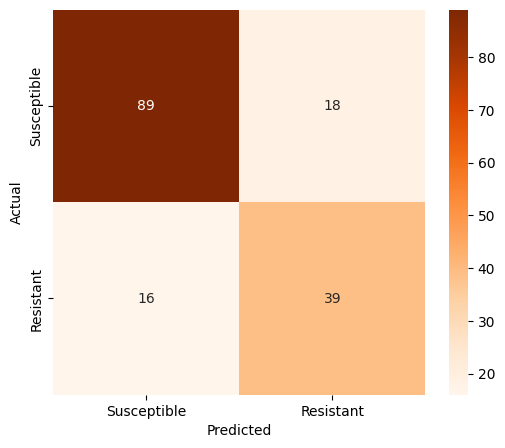

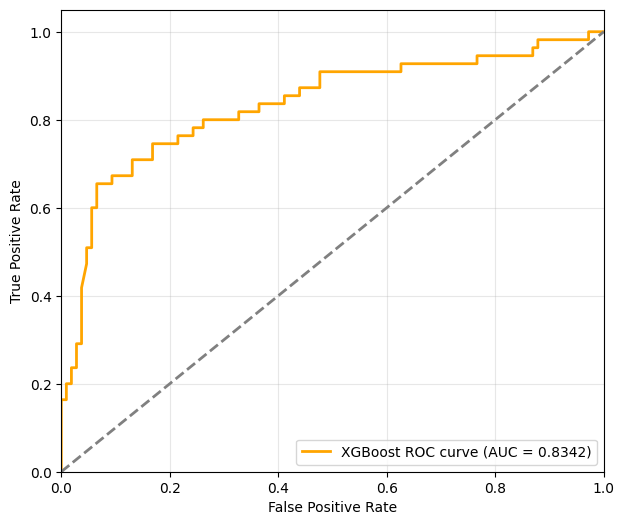

In [ ]:
print("\n--- Evaluating XGBoost Model on Test Set ---")

# --- Predictions ---
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_probs_xgb)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC Score: {auc_xgb:.4f}")
print(f"Cohen's Kappa: {kappa_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report_xgb)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.show()

# --- ROC Curve ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_probs_xgb)
plt.figure(figsize=(7, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost ROC curve (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- XGBoost Explainability: SHAP Feature Importances ---
Calculating SHAP values for the test set...
Plotting global SHAP feature importance...


/tmp/ipython-input-2517317453.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


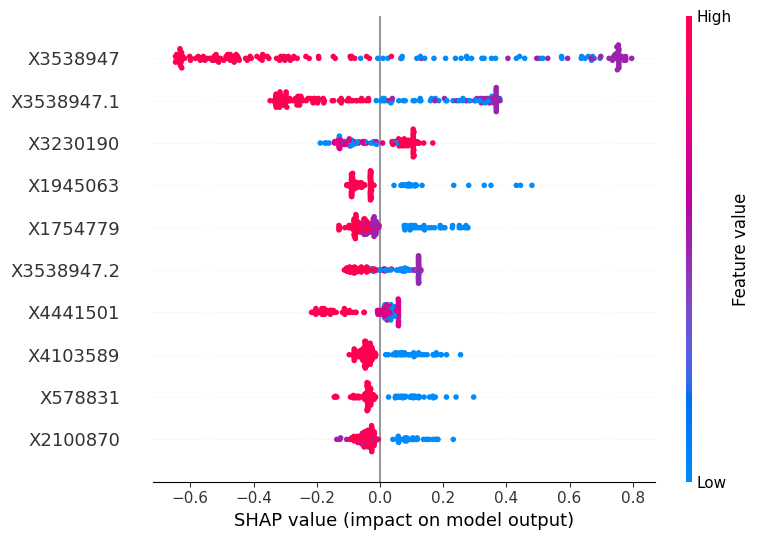


Explaining prediction for test sample index 0 (SHAP force plot)...


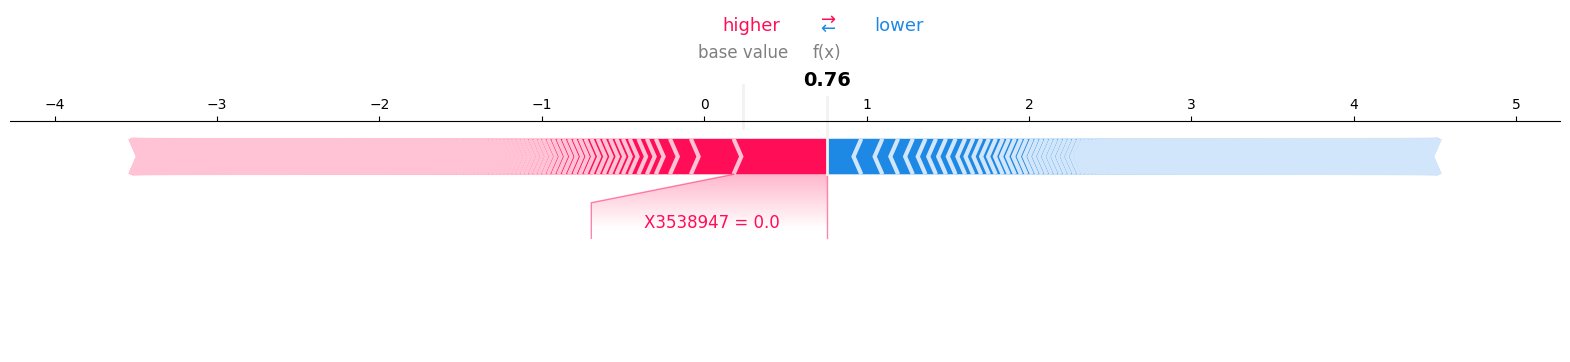


--- Explainability Analysis Complete ---
In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.
A high SHAP value means that feature pushed the prediction towards 'Resistant'.


In [ ]:
print("\n--- XGBoost Explainability: SHAP Feature Importances ---")

explainer_xgb = shap.TreeExplainer(xgb_model)

print("Calculating SHAP values for the test set...")
shap_values_xgb = explainer_xgb.shap_values(X_test)

X_test_df = pd.DataFrame(X_test, columns=snp_position_names)

# --- Global Feature Importance Plot (SHAP Summary Plot) ---
print("Plotting global SHAP feature importance...")
plt.figure()
shap.summary_plot(
    shap_values_xgb,
    X_test_df,
    max_display=10,
    show=False
)
#plt.title(f'Top SHAP Feature Importances for {TARGET_ANTIBIOTIC} (XGBoost)')
plt.tight_layout()
plt.show()

# --- Individual Prediction Explanation (Force Plot) ---
sample_to_explain_idx = 0
print(f"\nExplaining prediction for test sample index {sample_to_explain_idx} (SHAP force plot)...")
shap.initjs()
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_to_explain_idx, :],
    X_test_df.iloc[sample_to_explain_idx, :],
    matplotlib=True,
    show=True
)

print("\n--- Explainability Analysis Complete ---")
print("In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.")
print("A high SHAP value means that feature pushed the prediction towards 'Resistant'.")

# **GEN**

In [ ]:
# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "GEN"

# Data Splitting Ratios
TEST_SPLIT = 0.2

np.random.seed(42)

print("Setup Complete. Using XGBoost for classification.")

Setup Complete. Using XGBoost for classification.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

snp_position_names = features_df.columns.tolist()

X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 188, Susceptible (0): 621


# **Data Splitting**

In [ ]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


# **Model Definition & Training**

In [ ]:
print("\n--- Defining and Training the XGBoost Model ---")

# --- Hyperparameter Selection ---
neg_count, pos_count = np.bincount(y_train)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.4f}")

# Other common hyperparameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'random_state': 42,
    #'tree_method': 'gpu_hist',
    'early_stopping_rounds': 50
}

# --- Model Instantiation ---
xgb_model = xgb.XGBClassifier(**xgb_params)

print(f"Training XGBoost with up to {xgb_params['n_estimators']} trees...")

# --- Training ---
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"\nTraining complete. Best iteration found at tree #{xgb_model.best_iteration}")

# --- SAVING THE FINAL MODEL ---
XGB_MODEL_PATH = "best_xgboost_model_GEN.json"
print(f"Saving the final XGBoost model to {XGB_MODEL_PATH}...")
xgb_model.save_model(XGB_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the XGBoost Model ---
Calculated scale_pos_weight for XGBoost: 3.3133
Training XGBoost with up to 1000 trees...

Training complete. Best iteration found at tree #65
Saving the final XGBoost model to best_xgboost_model_GEN.json...
Model saved successfully.


# **Model Evaluation**


--- Evaluating XGBoost Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.7593
AUC Score: 0.7715
Cohen's Kappa: 0.3698
Matthews Correlation Coefficient (MCC): 0.3722

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8632    0.8145    0.8382       124
  Resistant (1)     0.4889    0.5789    0.5301        38

       accuracy                         0.7593       162
      macro avg     0.6761    0.6967    0.6841       162
   weighted avg     0.7754    0.7593    0.7659       162


Confusion Matrix:


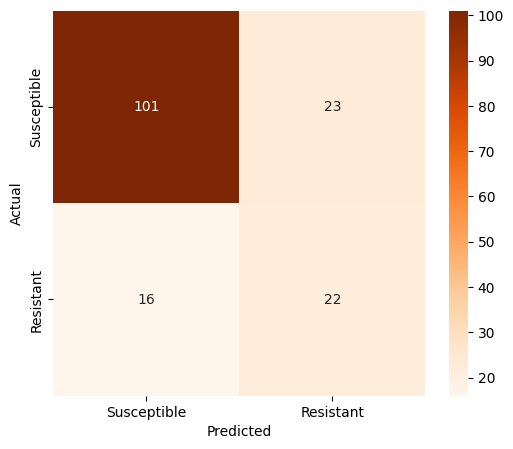

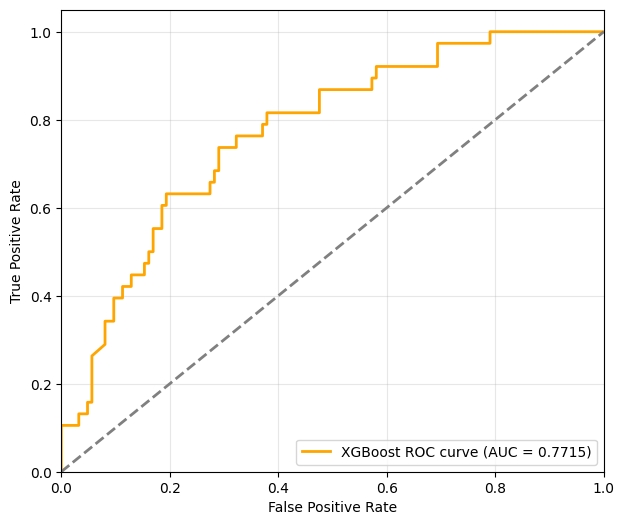

In [ ]:
print("\n--- Evaluating XGBoost Model on Test Set ---")

y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_probs_xgb)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC Score: {auc_xgb:.4f}")
print(f"Cohen's Kappa: {kappa_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report_xgb)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.show()

# --- ROC Curve ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_probs_xgb)
plt.figure(figsize=(7, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost ROC curve (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (XGBoost)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- XGBoost Explainability: SHAP Feature Importances ---
Calculating SHAP values for the test set...
Plotting global SHAP feature importance...


/tmp/ipython-input-2517317453.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


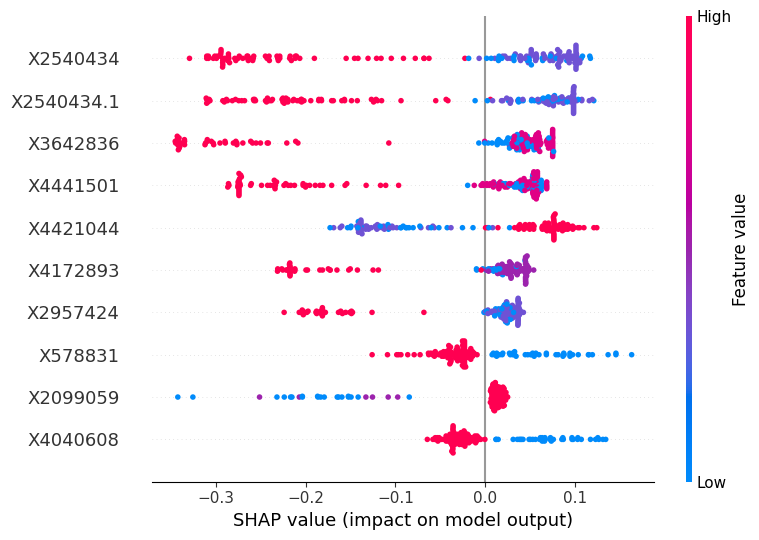


Explaining prediction for test sample index 0 (SHAP force plot)...


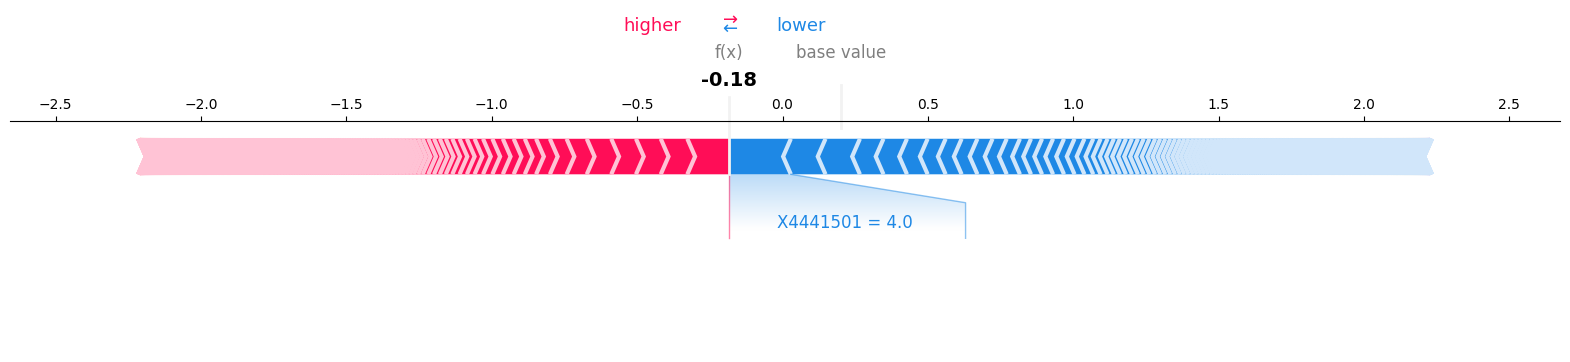


--- Explainability Analysis Complete ---
In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.
A high SHAP value means that feature pushed the prediction towards 'Resistant'.


In [ ]:
print("\n--- XGBoost Explainability: SHAP Feature Importances ---")

explainer_xgb = shap.TreeExplainer(xgb_model)

print("Calculating SHAP values for the test set...")
shap_values_xgb = explainer_xgb.shap_values(X_test)

X_test_df = pd.DataFrame(X_test, columns=snp_position_names)

# --- Global Feature Importance Plot (SHAP Summary Plot) ---
print("Plotting global SHAP feature importance...")
plt.figure()
shap.summary_plot(
    shap_values_xgb,
    X_test_df,
    max_display=10,
    show=False
)
#plt.title(f'Top SHAP Feature Importances for {TARGET_ANTIBIOTIC} (XGBoost)')
plt.tight_layout()
plt.show()

# --- Individual Prediction Explanation (Force Plot) ---
sample_to_explain_idx = 0
print(f"\nExplaining prediction for test sample index {sample_to_explain_idx} (SHAP force plot)...")
shap.initjs()
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_to_explain_idx, :],
    X_test_df.iloc[sample_to_explain_idx, :],
    matplotlib=True,
    show=True
)

print("\n--- Explainability Analysis Complete ---")
print("In the summary plot, each dot is a sample. Red dots mean high feature value, blue means low.")
print("A high SHAP value means that feature pushed the prediction towards 'Resistant'.")